本练习中使用高斯模型实现异常检测算法，并将其应用于检测网络上的故障服务器。我们还将看到如何使用协作过滤构建推荐系统，并将其应用于电影推荐数据集。
# 1 Anomaly detection（异常检测）
使用高斯模型来检测数据集中未标记的示例是否应被视为异常。先从简单的二维数据集开始。

**数据可视化**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
data = loadmat('Machine_Learning_Ex/machine-learning-ex8/ex8/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

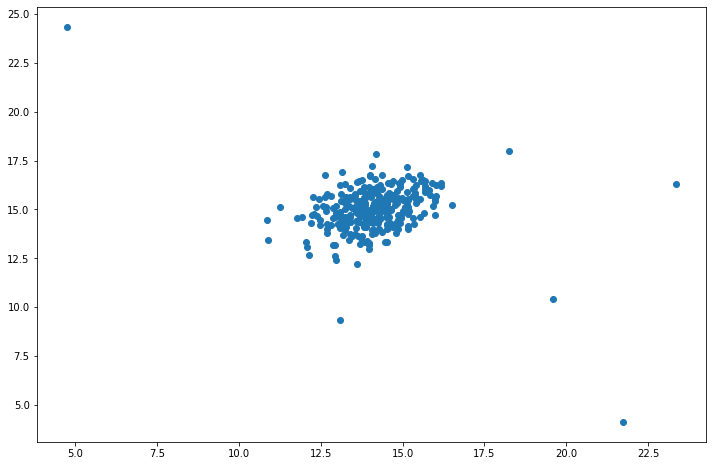

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

这是一个非常紧密的聚类，几个值远离了聚类。 在这个简单的例子中，这些可以被认为是异常的。为了弄清楚，为数据中的每个特征估计高斯分布。为此创建一个返回每个要素的均值和方差的函数。
## 1.1 高斯分布
需要为每个特征$x_i$拟合一个高斯分布，并返回高斯分布的参数$\pu,\sigma_i^2$。高斯分布公式如下：

$$p(x;\pu,\sigma^2)=\frac{1}{\sqrt(2\pi\sigma^2)}e^{-\frac{(x-\pu)^2}{2\sigma^2}}$$

其中，$\pu$是平均值，$\sigma^2$是方差

## 1.2 计算高斯分布参数

$$\mu_i=\frac{1}{m}\sum^m_{j=1}x^{(i)}_i$$

$$\sigma^2_i=\frac{1}{m}\sum^m_{j=1}(x^{(j)}-\mu_i)^2$$

接下来要输入一个X矩阵，输出2个n维的向量，$\mu$包含了每一个维度的平均值，$\sigma^2$包含了每一个维度的方差。

In [4]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [5]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

**数据可视化**

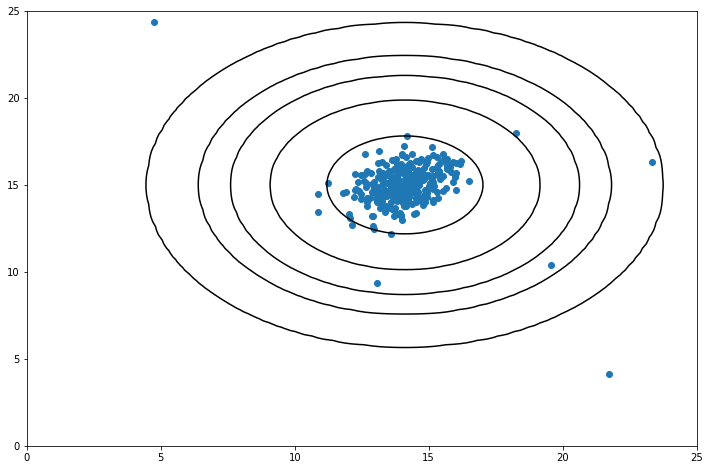

In [6]:
xplot = np.linspace(0,25,100)
yplot = np.linspace(0,25,100)
Xplot, Yplot = np.meshgrid(xplot,yplot)
Z = np.exp((-0.5)*((Xplot-mu[0])**2/sigma[0]+(Yplot-mu[1])**2/sigma[1]))

fig, ax = plt.subplots(figsize=(12,8))
contour = plt.contour(Xplot, Yplot, Z,[10**-11, 10**-7, 10**-5, 10**-3, 0.1],colors='k')
ax.scatter(X[:,0], X[:,1])
plt.show()

# 1.3 选择阈值ε
有了参数后，可以估计每组数据的概率，低概率的数据点更可能是异常的。确定异常点需要先确定一个阈值，可以通过验证集集来确定这个阈值。

In [7]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

还需要一种计算数据点属于正态分布的概率的方法。 幸运的是SciPy有这个内置的方法。

In [8]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

还可以将数组传递给概率密度函数，并获得数据集中每个点的概率密度。

In [9]:
dist.pdf(X[:,0])[0:50]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ,
       0.21716057, 0.21760472, 0.20141857, 0.20157497, 0.21711385,
       0.21758775, 0.21695576, 0.2138258 , 0.21057069, 0.1173018 ,
       0.20765108, 0.21717452, 0.19510663, 0.21702152, 0.17429399,
       0.15413455, 0.21000109, 0.20223586, 0.21031898, 0.21313426,
       0.16158946, 0.2170794 , 0.17825767, 0.17414633, 0.1264951 ,
       0.19723662, 0.14538809, 0.21766361, 0.21191386, 0.21729442,
       0.21238912, 0.18799417, 0.21259798, 0.21752767, 0.20616968,
       0.21520366, 0.1280081 , 0.21768113, 0.21539967, 0.16913173])

计算并保存给定上述的高斯模型参数的数据集中每个值的概率密度

In [10]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

还需要为验证集（使用相同的模型参数）执行此操作。使用与真实标签组合的这些概率来确定将数据点分配为异常的最佳概率阈值。

In [11]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

需要一个函数，找到给定概率密度值和真实标签的最佳阈值。 为了做到这一点，我们将为不同的epsilon值计算F1分数。 F1是真阳性，假阳性和假阴性的数量的函数。 方程式在练习文本中。

In [12]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [13]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.009566706005956842, 0.7142857142857143)

最后可以将阈值应用于数据集，并可视化结果。

In [14]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

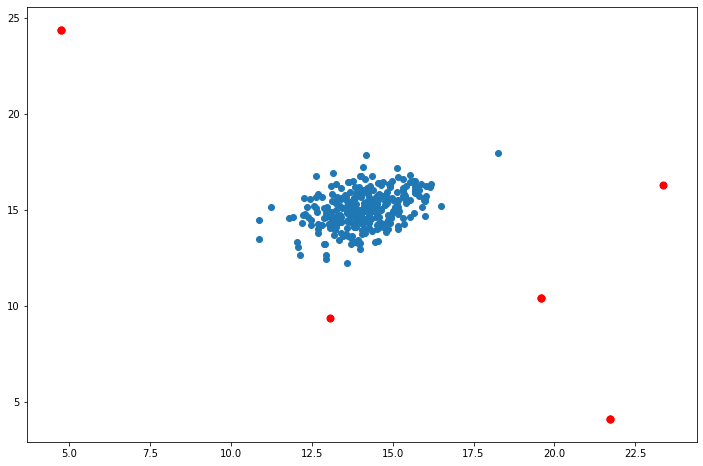

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()

红点是被标记为异常值的点。这些看起来很合理。有一些分离（但没有被标记）的右上角也可能是一个异常值，但是相当接近。

# 2协同过滤

推荐引擎使用基于项目和用户的相似性度量来检查用户的历史偏好，以便为用户可能感兴趣的新“事物”提供建议。本练习中将实现一种称为协作过滤的特定推荐系统算法，并将其应用于 电影评分的数据集。

首先加载并检查将要使用的数据。

In [16]:
data = loadmat('Machine_Learning_Ex/machine-learning-ex8/ex8/ex8_movies.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

Y是包含从1到5的等级的（数量的电影x数量的用户）数组。R是包含指示用户是否给电影评分的二进制值的“指示符”数组。两者应该具有相同的维度。

In [17]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

可以通过平均排序Y来评估电影的平均评级

In [18]:
Y[1,np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

还可以通过将矩阵渲染成图像来尝试“可视化”数据。不能从这里收集太多，但它确实给我们了解用户和电影的相对密度。

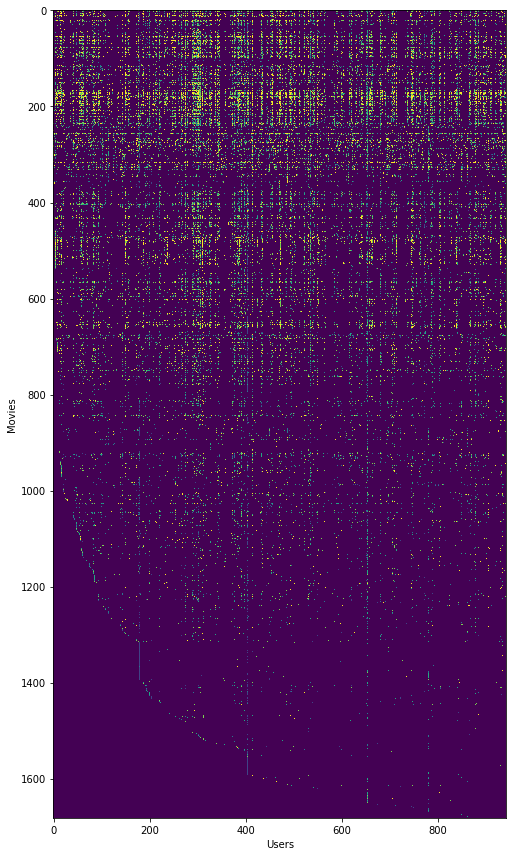

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()
plt.show()

接下来实施协同过滤的代价函数。直觉上，“代价”是指一组电影评级预测偏离真实预测的程度。代价方程在练习文本中给出。它基于文本中称为X和Theta的两组参数矩阵。这些“展开”到“参数”输入中，以便稍后可以使用SciPy的优化包。注意已经在注释中包含数组/矩阵形状（对于在本练习中使用的数据），以帮助说明矩阵交互如何工作。

## 2.1cost
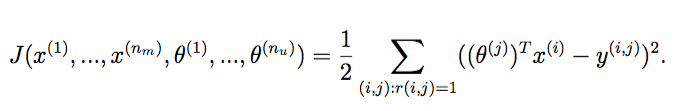

In [20]:
def serialize(X, theta):
    """序列化两个矩阵
    """
    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    return np.concatenate((X.ravel(), theta.ravel()))


def deserialize(param, n_movie, n_user, n_features):
    """逆序列化"""
    return param[:n_movie * n_features].reshape(n_movie, n_features), param[n_movie * n_features:].reshape(n_user, n_features)


# recommendation fn
def cost(param, Y, R, n_features):
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)

    return np.power(inner, 2).sum() / 2

为了测试这一点，提供了一组可以评估的预训练参数。为了保持评估时间的少点，将只看一小段数据。

In [21]:
params_data = loadmat('Machine_Learning_Ex/machine-learning-ex8/ex8/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [22]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, theta_sub)

cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [23]:
param = serialize(X, Theta)  # total real params

cost(serialize(X, Theta), Y, R, 10)  # this is real total cost

27918.64012454421

## 2.2gradient
接下来需要实现梯度计算。 就像在练习4中使用神经网络实现一样，将扩展代价函数来计算梯度。

In [24]:
def gradient(param, Y, R, n_features):
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943)

    # X_grad (1682, 10)
    X_grad = inner @ theta

    # theta_grad (943, 10)
    theta_grad = inner.T @ X

    # roll them together and return
    return serialize(X_grad, theta_grad)

In [25]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(gradient(param, Y, R, 10),n_movie, n_user, 10)
X_grad, theta_grad

(array([[-6.26184144,  2.45936046, -6.87560329, ..., -4.81611896,
          3.84341521, -1.88786696],
        [-3.80931446,  1.80494255, -2.63877955, ..., -3.55580057,
          2.1709485 ,  2.65129032],
        [-3.13090116,  2.54853961,  0.23884578, ..., -4.18778519,
          3.10538294,  5.47323609],
        ...,
        [-1.04774171,  0.99220776, -0.48920899, ..., -0.75342146,
          0.32607323, -0.89053637],
        [-0.7842118 ,  0.76136861, -1.25614442, ..., -1.05047808,
          1.63905435, -0.14891962],
        [-0.38792295,  1.06425941, -0.34347065, ..., -2.04912884,
          1.37598855,  0.19551671]]),
 array([[-1.54728877,  9.0812347 , -0.6421836 , ..., -3.92035321,
          5.66418748,  1.16465605],
        [-2.58829914,  2.52342335, -1.52402705, ..., -5.46793491,
          5.82479897,  1.8849854 ],
        [ 2.14588899,  2.00889578, -4.32190712, ..., -6.83365682,
          1.78952063,  0.82886788],
        ...,
        [-4.59816821,  3.63958389, -2.52909095, ..., -

## 2.3regularized cost & regularized gradient
下一步是在代价和梯度计算中添加正则化。将创建一个最终的正则化版本的功能（请注意，此版本包含一个额外的“学习率”参数，在文本中称为“lambda”）。

In [26]:
def regularized_cost(param, Y, R, n_features, l=1):
    reg_term = np.power(param, 2).sum() * (l / 2)

    return cost(param, Y, R, n_features) + reg_term


def regularized_gradient(param, Y, R, n_features, l=1):
    grad = gradient(param, Y, R, n_features)
    reg_term = l * param

    return grad + reg_term

In [27]:
regularized_cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [28]:
regularized_cost(param, Y, R, 10, l=1)  # total regularized cost


32520.682450229557

In [29]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(regularized_gradient(param, Y, R, 10),
                                                                n_movie, n_user, 10)

这个结果再次与练习代码的预期输出相匹配，所以看起来正则化是正常的。在训练模型之前,有一个最后步骤，任务是创建自己的电影评分，以便可以使用该模型来生成个性化的推荐。 为我们提供一个连接电影索引到其标题的文件。接着将文件加载到字典中。

In [30]:
movie_list = []
f = open('Machine_Learning_Ex/machine-learning-ex8/ex8/movie_ids.txt',encoding= 'ISO-8859-1')

for line in f:
    tokens = line.strip().split(' ')
    movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)
# encoding= 'gbk'报错：
# 'gbk' codec can't decode byte 0xe9 in position 6679: illegal multibyte sequence

In [31]:
movie_list[0]

'Toy Story (1995)'

将使用练习中提供的评分

In [32]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

ratings.shape

(1682, 1)

可以将自己的评级向量添加到现有数据集中以包含在模型中

In [33]:
Y = data['Y']
Y = np.append(ratings,Y, axis=1)  # now I become user 0
print(Y.shape)

(1682, 944)


In [34]:
R = data['R']
R = np.append( ratings != 0, R,axis=1)
R.shape

(1682, 944)

不只是准备训练协同过滤模型。只需要定义一些变量并对评级进行规一化。

In [35]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
theta = np.random.random(size=(users, features))
params = serialize(X, theta)

X.shape, theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

不只是准备训练协同过滤模型。只需要定义一些变量并对评级进行规一化。

In [36]:
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

## 2.4traing

In [37]:
from scipy.optimize import minimize

fmin = minimize(fun=regularized_cost, x0=params, args=(Y_norm, R, features, learning_rate), 
                method='TNC', jac=regularized_gradient)
fmin

     fun: 69380.70267950642
     jac: array([ 3.19859842e-05, -3.14882110e-05, -2.91142119e-05, ...,
       -5.35817776e-06,  1.80931260e-06, -1.31476056e-05])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1080
     nit: 41
  status: 1
 success: True
       x: array([ 0.47679892,  0.53753049,  1.09386871, ..., -0.02986926,
        0.73776223,  0.91085348])

训练好的参数是X和Theta。可以使用这些来为我们添加的用户创建一些建议。

In [38]:
X_trained, theta_trained = deserialize(fmin.x, movies, users, features)
X_trained.shape, theta_trained.shape

((1682, 10), (944, 10))

最后，使用训练出的数据给出推荐电影

In [39]:
prediction = X_trained @ theta_trained.T
my_preds = prediction[:, 0] + Y.mean()
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [40]:
# top ten idx
my_preds[idx][:10]

array([4.28262541, 4.11499   , 3.98045151, 3.90580245, 3.88817821,
       3.87460903, 3.87179144, 3.8652742 , 3.76237683, 3.7539418 ])

In [41]:
for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Raiders of the Lost Ark (1981)
Good Will Hunting (1997)
Shawshank Redemption, The (1994)
Braveheart (1995)
Return of the Jedi (1983)
Empire Strikes Back, The (1980)
Terminator 2: Judgment Day (1991)
As Good As It Gets (1997)
